<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA365_Project_Final_Ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy import stats

# Data

In [134]:
url = 'https://raw.githubusercontent.com/Eggathin/expert-octo-pancake/main/ObesityDataSet.csv?token=GHSAT0AAAAAACM7646T6U2T3E4XG3SNR5MMZQTQDFQ'
df = pd.read_csv(url)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [135]:
obesity_ordinal_mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
df['NObeyesdad'] = df['NObeyesdad'].map(obesity_ordinal_mapping)
df['SMOKE'] = df['SMOKE'].map({'yes': 1, 'no': 0})
df['SCC'] = df['SCC'].map({'yes': 1, 'no': 0})
df['FAVC'] = df['FAVC'].map({'yes': 1, 'no': 0})
df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'yes': 1, 'no': 0})
df['CALC'] = df['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['CAEC'] = df['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,1,0,2.000000,0,0.000000,1.000000,0,Public_Transportation,1
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,1,Public_Transportation,1
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,1,0,2.000000,0,2.000000,1.000000,2,Public_Transportation,1
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,1,0,2.000000,0,2.000000,0.000000,2,Walking,2
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,1,0,2.000000,0,0.000000,0.000000,1,Public_Transportation,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,1,0,1.728139,0,1.676269,0.906247,1,Public_Transportation,6
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,1,0,2.005130,0,1.341390,0.599270,1,Public_Transportation,6
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,1,0,2.054193,0,1.414209,0.646288,1,Public_Transportation,6
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,1,0,2.852339,0,1.139107,0.586035,1,Public_Transportation,6


# Variable Selection

In [88]:
y = df['NObeyesdad']
X = df.drop(columns=['NObeyesdad', 'MTRANS'])

In [89]:
p=15

with pm.Model() as model:
    # Priors for the inclusion probabilities (slab weights)
    inclusion_probs = pm.Beta('inclusion_probs', alpha=1, beta=1, shape=p)

    # Spike and slab priors for the coefficients
    tau = 0.01  # Variance for the spike
    slab_scale = 5  # Scale for the slab
    beta_spike_slab = pm.Normal('beta_spike_slab', mu=0, sigma=pm.math.sqrt(tau + inclusion_probs * (slab_scale**2 - tau)), shape=p)

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta_spike_slab)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

In [90]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inclusion_probs[0],0.367,0.292,0.002,0.888,0.004,0.003,5217.0,2772.0,1.0
inclusion_probs[1],0.339,0.300,0.000,0.896,0.005,0.003,3560.0,2115.0,1.0
inclusion_probs[2],0.481,0.271,0.048,0.938,0.005,0.004,3021.0,1728.0,1.0
inclusion_probs[3],0.341,0.295,0.000,0.884,0.005,0.003,3187.0,2243.0,1.0
inclusion_probs[4],0.350,0.293,0.000,0.888,0.005,0.004,3062.0,2342.0,1.0
inclusion_probs[5],0.344,0.299,0.000,0.882,0.005,0.004,3492.0,2295.0,1.0
inclusion_probs[6],0.346,0.296,0.000,0.882,0.004,0.003,4132.0,2862.0,1.0
inclusion_probs[7],0.343,0.296,0.000,0.883,0.004,0.003,3603.0,2228.0,1.0
inclusion_probs[8],0.346,0.299,0.000,0.895,0.005,0.003,3858.0,2763.0,1.0
inclusion_probs[9],0.353,0.298,0.000,0.896,0.004,0.003,3937.0,2160.0,1.0


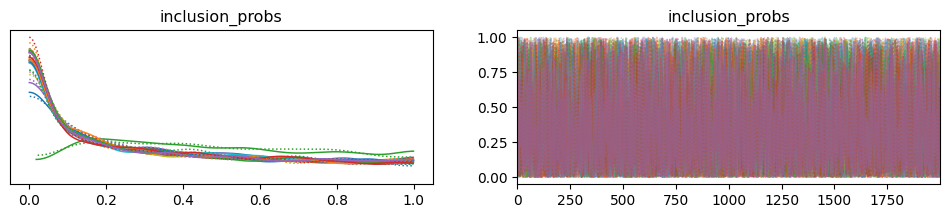

In [91]:
az.plot_trace(trace, var_names=['inclusion_probs'])
az.summary(trace, var_names=['inclusion_probs'])

# Dataset size reduction

In [92]:
smaller_df = df.iloc[::4, :].reset_index(drop=True)
smaller_df = smaller_df.drop(columns=['Height'])

# Hierarchical model

In [93]:
y = smaller_df['NObeyesdad']
X = smaller_df.drop(columns=['NObeyesdad', 'MTRANS'])
MTRANS = smaller_df['MTRANS'].astype('category').cat.codes
n_groups = len(np.unique(MTRANS))

with pm.Model() as hierarchical_model:
    # Priors for group-level parameters
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal('sigma_alpha', 10)

    # Group-level intercepts
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_groups)

    # Priors for other parameters
    sigma_betas = pm.HalfNormal('sigma_betas', 10)
    betas = pm.Normal('betas', mu=0, sigma=sigma_betas, shape=X.shape[1])
    K = len(np.unique(y))
    thresholds = pm.Normal('thresholds', mu=np.arange(K-1), sigma=10, shape=K-1, transform=pm.distributions.transforms.ordered)

    # Linear predictor
    eta = alpha[MTRANS] + pm.math.dot(X, betas)

    # Likelihood
    likelihood = pm.OrderedLogistic('likelihood', eta=eta, cutpoints=thresholds, observed=y)

In [94]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, return_inferencedata=True)

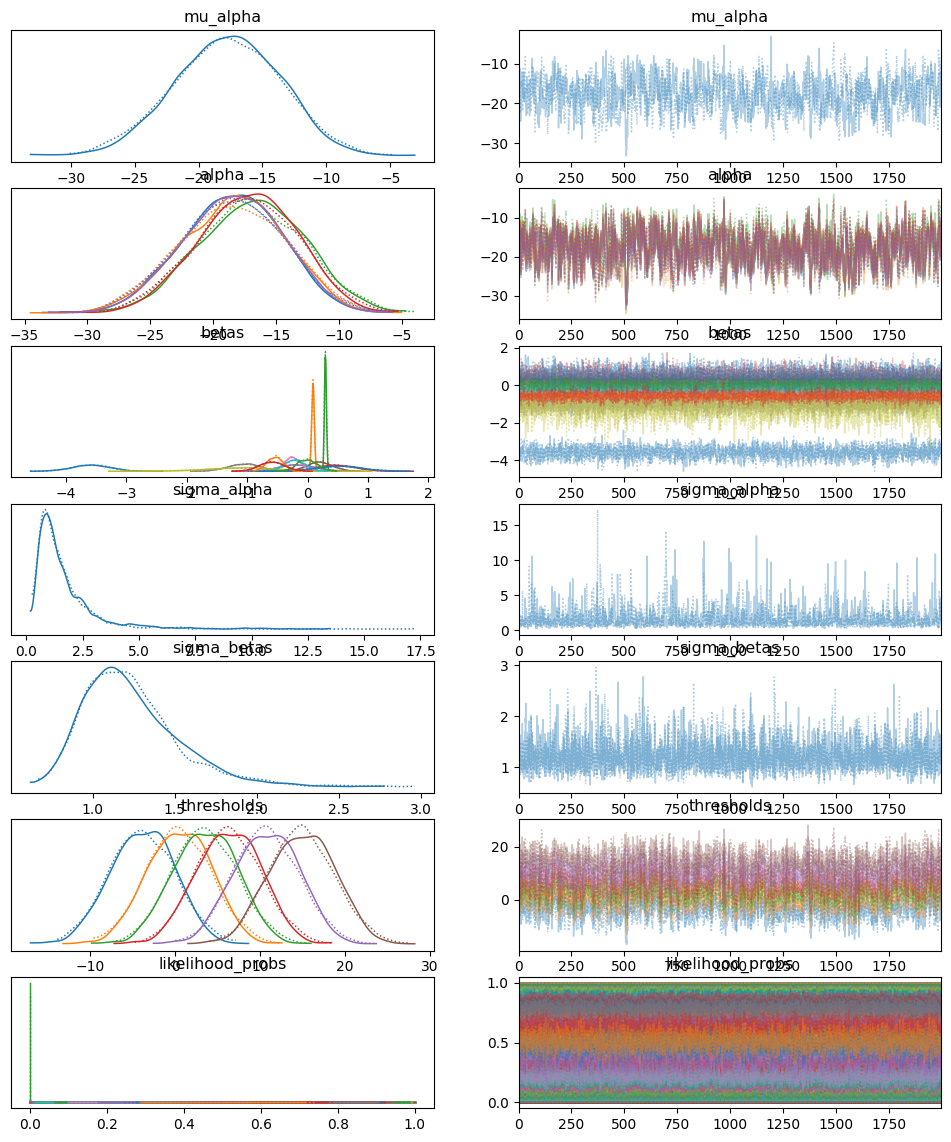

In [95]:
with hierarchical_model:
  az.plot_trace(hierarchical_trace)

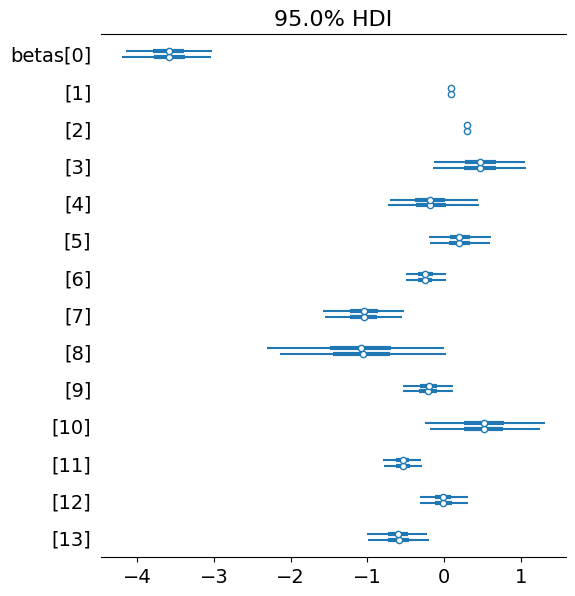

In [115]:
az.plot_forest(hierarchical_trace, var_names=['betas'], combined=False, hdi_prob=0.95);

In [98]:
az.summary(hierarchical_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-17.764,4.123,-25.571,-10.301,0.176,0.125,549.0,1053.0,1.01
alpha[0],-18.567,4.028,-26.062,-11.099,0.177,0.125,524.0,1100.0,1.01
alpha[1],-18.451,4.216,-26.676,-11.094,0.178,0.126,566.0,1202.0,1.01
alpha[2],-16.974,4.257,-24.876,-8.995,0.178,0.126,578.0,1128.0,1.01
alpha[3],-17.274,3.993,-24.753,-9.835,0.175,0.124,527.0,1038.0,1.01
...,...,...,...,...,...,...,...,...,...
"likelihood_probs[527, 2]",0.000,0.000,0.000,0.000,0.000,0.000,1474.0,1930.0,1.00
"likelihood_probs[527, 3]",0.000,0.000,0.000,0.000,0.000,0.000,1566.0,1988.0,1.00
"likelihood_probs[527, 4]",0.000,0.000,0.000,0.000,0.000,0.000,1737.0,2472.0,1.00
"likelihood_probs[527, 5]",0.001,0.001,0.000,0.002,0.000,0.000,2099.0,2984.0,1.00


<Axes: xlabel='likelihood / likelihood'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


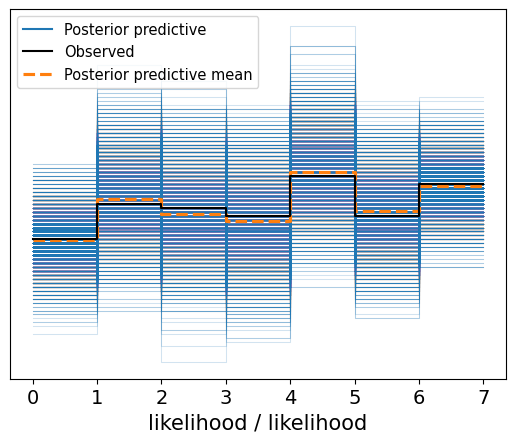

In [97]:
ppc2 = pm.sample_posterior_predictive(hierarchical_trace, model=hierarchical_model)
az.plot_ppc(ppc2)

# Pooled model

In [100]:
y = smaller_df['NObeyesdad']
X = smaller_df.drop(columns=['NObeyesdad'])
X['MTRANS'] = smaller_df['MTRANS'].map({'Automobile': 0, 'Public_Transportation': 1, 'Motorbike': 2, 'Bike': 3, 'Walking':4})

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', 10)
    betas = pm.Normal('betas', mu=0, sigma=sigma, shape=X.shape[1])
    K = len(np.unique(smaller_df['NObeyesdad']))
    thresholds = pm.Normal('thresholds', mu=np.arange(K-1), sigma=10, shape=K-1, transform=pm.distributions.transforms.ordered)

    # Linear predictor
    eta = alpha + pm.math.dot(X, betas)

    # Likelihood
    likelihood = pm.OrderedLogistic('likelihood', eta=eta, cutpoints=thresholds, observed=y)


In [101]:
with model:
  trace = pm.sample(2000, return_inferencedata=True)

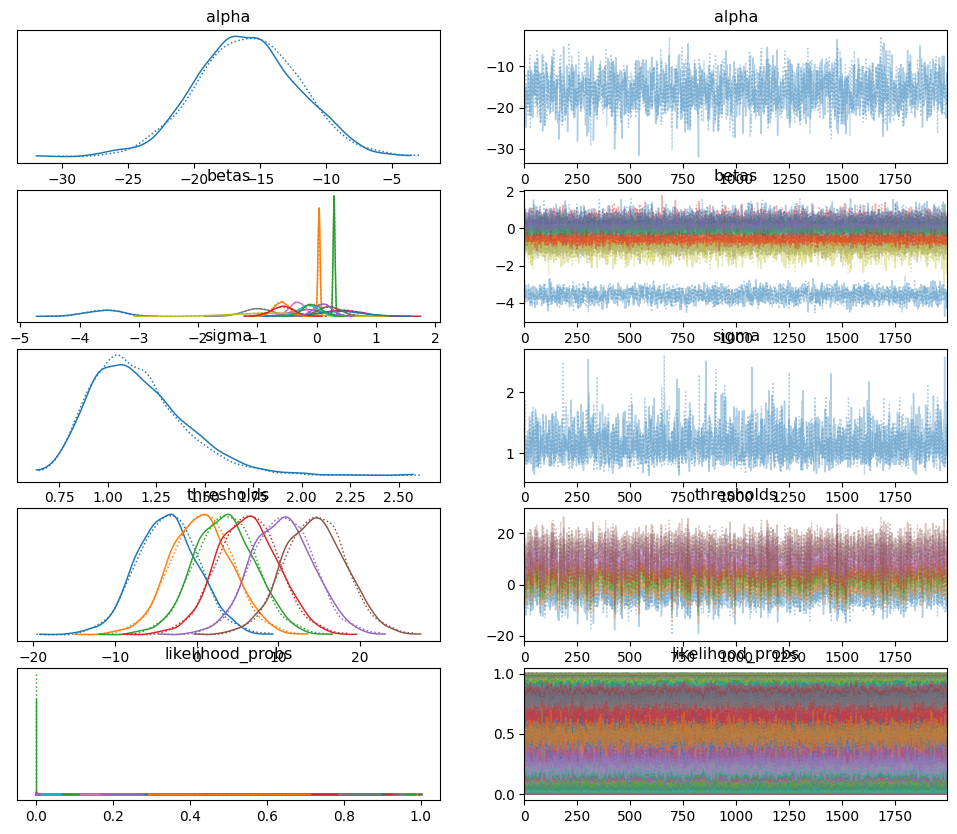

In [102]:
with model:
  az.plot_trace(trace)

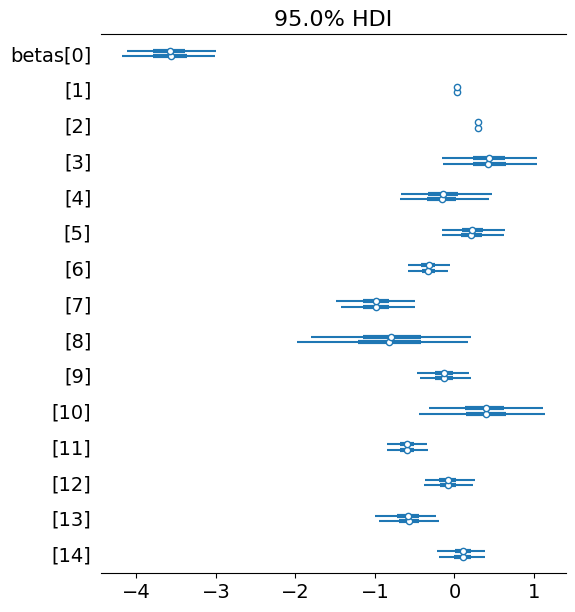

In [117]:
az.plot_forest(trace, var_names=['betas'], combined=False, hdi_prob=0.95);

<Axes: xlabel='likelihood / likelihood'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


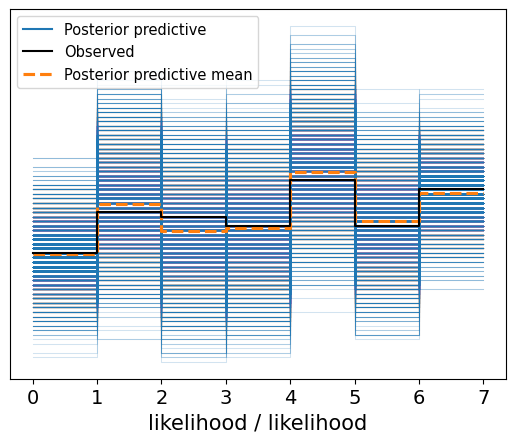

In [103]:
ppc = pm.sample_posterior_predictive(trace, model=model)
az.plot_ppc(ppc)

# Model Comparison

In [104]:
with model:
    pm.compute_log_likelihood(trace)

In [105]:
with hierarchical_model:
  pm.compute_log_likelihood(hierarchical_trace)

In [108]:
# Weak priors, so LOO is prefered
az.compare({"hierarchical": hierarchical_trace, "pooled": trace}, ic='loo')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-397.416038,23.80393,0.00000,0.955826,14.492586,0.000000,False,log
pooled,1,-407.686798,21.85125,10.27076,0.044174,14.598959,4.760798,False,log


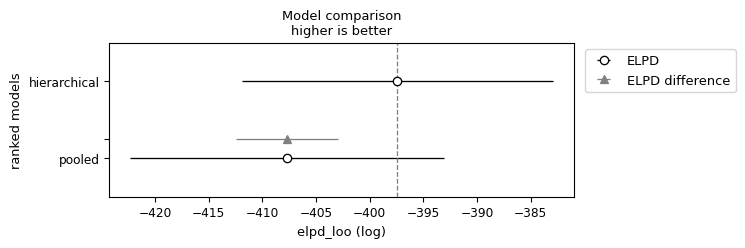

In [111]:
az.plot_compare(az.compare({"hierarchical": hierarchical_trace, "pooled": trace}), insample_dev=False);

In [122]:
az.loo(hierarchical_trace)

<ipython-input-122-bd4eff6fcd15>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.loo(hierarchical_trace)


Computed from 4000 posterior samples and 528 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -397.42    14.49
p_loo       23.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      527   99.8%
 (0.5, 0.7]   (ok)          1    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [123]:
az.loo(trace)

<ipython-input-123-524897da6cf1>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.loo(trace)


Computed from 4000 posterior samples and 528 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -407.69    14.60
p_loo       21.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      528  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%